## **0. Download dataset**
**Note:** If you can't download using gdown due to limited number of downloads, please download it manually and upload it to your drive, then copy it from the drive to colab.
```python
from google.colab import drive

drive.mount('/content/drive')
!cp /path/to/dataset/on/your/drive .
```

In [13]:
# https://drive.google.com/file/d/1GaTMURqIQTjtalbNVAyVgPIEis21A0r8/view?usp=drive_link
# !gdown --id 1GaTMURqIQTjtalbNVAyVgPIEis21A0r8

In [14]:
# !unzip -q './FER-2013.zip'

## **1. Import libraries**

In [15]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize
from torchvision.io import read_image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

## **2. Get classes**

In [16]:
train_dir = 'train'
test_dir = 'test'

classes = os.listdir(train_dir)

label2idx = {cls:idx for idx, cls in enumerate(classes)}
idx2label = {idx:cls  for cls, idx in label2idx.items()}

## **3. Create PyTorch DataLoader**

In [17]:
test_img_path = 'train/angry/Training_10118481.jpg'
img = cv2.imread(test_img_path)
img_height, img_width = (128, 128)
print(f'Image height: {img_height}')
print(f'Image width: {img_width}')

Image height: 128
Image width: 128


In [18]:
class ImageDataset(Dataset):
    def __init__(self, img_dir, norm, label2idx, split='train', train_ratio=0.8):
        self.resize = Resize((img_height, img_width))
        self.norm = norm
        self.split = split
        self.train_ratio = train_ratio
        self.img_dir = img_dir
        self.label2idx = label2idx
        self.img_paths, self.img_labels = self.read_img_files()

        if split in ['train', 'val'] and 'train' in img_dir.lower():
            train_data, val_data = train_test_split(
                list(zip(self.img_paths, self.img_labels)),
                train_size=train_ratio,
                random_state=random_state,
                stratify=self.img_labels,
            )

        if split == 'train':
            self.img_paths, self.img_labels = zip(*train_data)
        elif split == 'val':
            self.img_paths, self.img_labels = zip(*val_data)
    
    
    def read_img_files(self):
        img_paths = []
        img_labels = []
        
        for cls in self.label2idx.keys():
            for img in os.listdir(os.path.join(self.img_dir, cls)):
                img_paths.append(os.path.join(self.img_dir, cls, img))
                img_labels.append(cls)

        return img_paths, img_labels


    def __len__(self):
        return len(self.img_paths)


    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        cls = self.img_labels[idx]
        img = self.resize(read_image(img_path))
        img = img.type(torch.float32)
        label = self.label2idx[cls]
        
        if self.norm:
            img = (img / 127.5) - 1
            
        return img, label

In [19]:
batch_size = 256

train_dataset = ImageDataset(train_dir, True, 
                             label2idx, split='train')
train_loader = DataLoader(train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

val_dataset = ImageDataset(train_dir, True, 
                           label2idx, split='val')
val_loader = DataLoader(val_dataset, 
                        batch_size=batch_size, 
                        shuffle=False)

test_dataset = ImageDataset(test_dir, True, 
                            label2idx, split='test')
test_loader = DataLoader(test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)

C:\Users\chaum\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


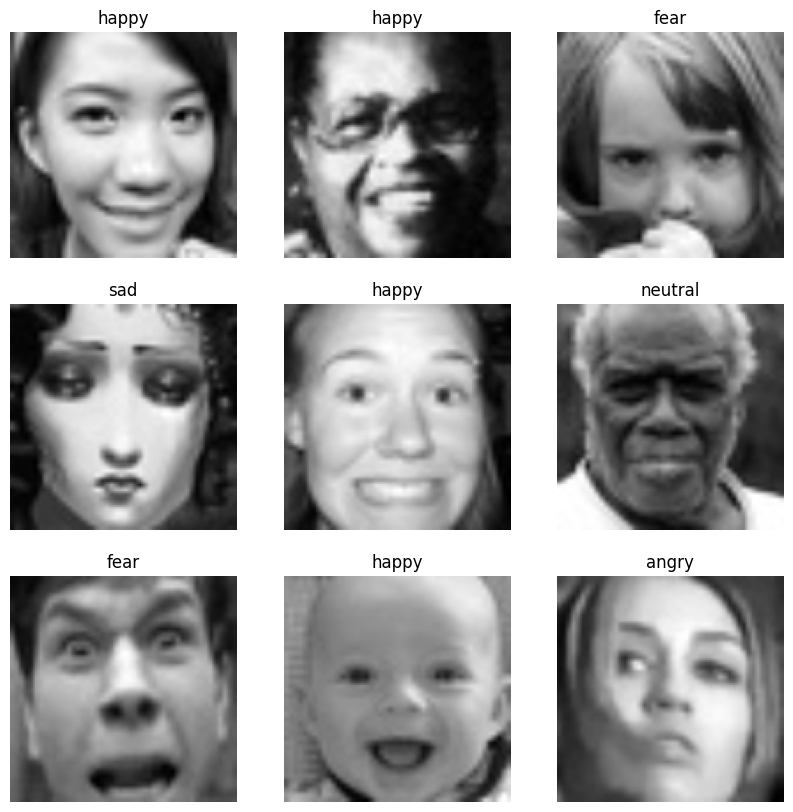

In [20]:
image_batch, label_batch = next(iter(train_loader))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    minv = image_batch[i].numpy().min()
    maxv = image_batch[i].numpy().max()
    plt.imshow(np.squeeze(image_batch[i].numpy()), vmin=minv, vmax=maxv, cmap="gray")
    label = label_batch[i]
    plt.title(idx2label[label.item()])
    plt.axis("off")

## **4. Build MLP network**

In [21]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims * 4)
        self.linear2 = nn.Linear(hidden_dims * 4, hidden_dims * 2)
        self.linear3 = nn.Linear(hidden_dims * 2, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        x = F.relu(x)
        out = self.output(x)
        return out.squeeze(1)

In [22]:
input_dims = img_height * img_width
output_dims = len(classes)
hidden_dims = 64

model = MLP(input_dims=input_dims, 
            hidden_dims=hidden_dims, 
            output_dims=output_dims).to(device)

In [23]:
lr = 1e-2
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

## **5. Training**

In [ ]:
epochs = 100
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    train_loss = 0.0
    train_target = []
    train_predict = []
    model.train()
    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        optimizer.zero_grad()
        outputs = model(X_samples)
        loss = criterion(outputs, y_samples)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        train_predict.append(outputs.detach().cpu())
        train_target.append(y_samples.cpu())

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    train_predict = torch.cat(train_predict)
    train_target = torch.cat(train_target)
    
    # Convert outputs to class labels if necessary
    train_predict_classes = torch.argmax(train_predict, dim=1)
    train_acc = accuracy_score(train_predict_classes.numpy(), 
                               train_target.numpy())
    train_accs.append(train_acc)

    val_loss = 0.0
    val_target = []
    val_predict = []
    model.eval()
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)
            outputs = model(X_samples)
            val_loss += criterion(outputs, y_samples).item()

            val_predict.append(outputs.cpu())
            val_target.append(y_samples.cpu())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    
    # Convert outputs to class labels if necessary
    val_predict_classes = torch.argmax(val_predict, dim=1)
    val_acc = accuracy_score(val_predict_classes.numpy(), 
                             val_target.numpy())
    val_accs.append(val_acc)

    print(f'\nEPOCH {epoch + 1}:\tTraining loss: {train_loss:.3f}\tValidation loss: {val_loss:.3f}')

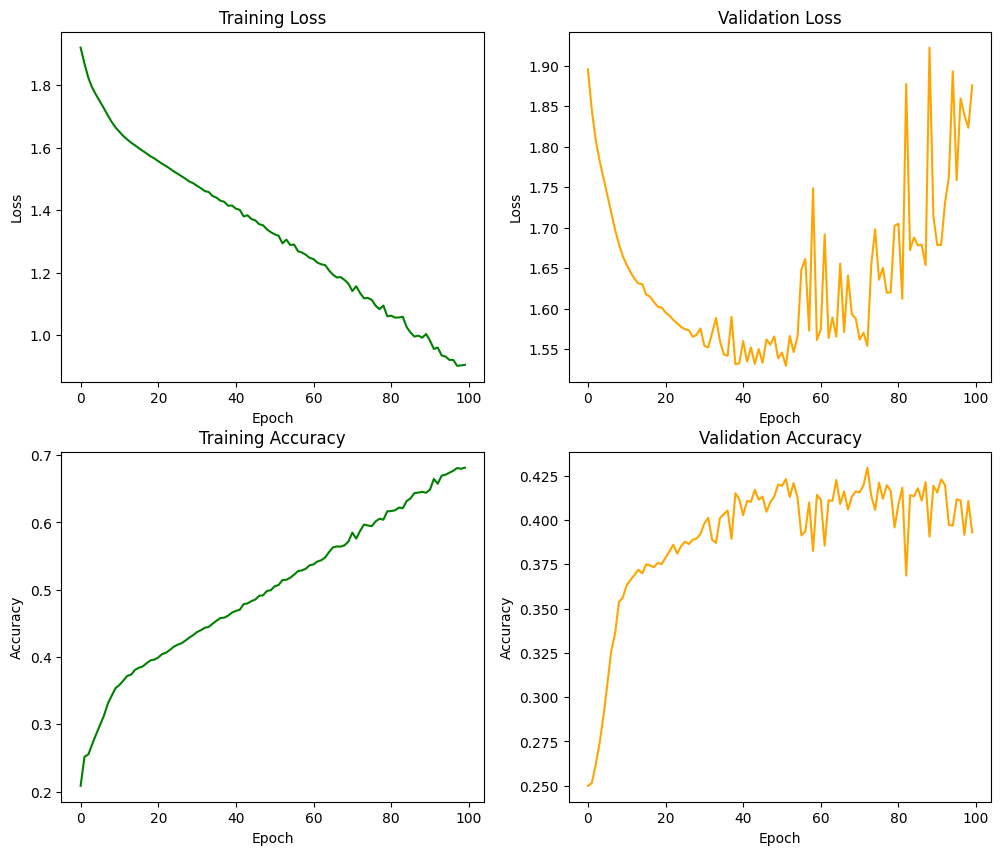

In [25]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_accs, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_accs, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

## **7. Evaluation**

In [26]:
val_target = []
val_predict = []
model.eval()
with torch.no_grad():
    for X_samples, y_samples in val_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        outputs = model(X_samples)

        val_predict.append(outputs.cpu())
        val_target.append(y_samples.cpu())

    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    
    # Convert outputs to class labels if necessary
    val_predict_classes = torch.argmax(val_predict, dim=1)
    val_acc = accuracy_score(val_predict_classes.numpy(), 
                             val_target.numpy())

    print('Evaluation on val set:')
    print(f'Accuracy: {val_acc}')

C:\Users\chaum\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Evaluation on val set:
Accuracy: 0.39306861720654823
